<a href="https://colab.research.google.com/github/tago893/capstone/blob/main/Arima_tested_daily_code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ethereum Predictions with ARIMA

## Contents:
* [Monthly Forecasting](#monthlyForecasting)
    * [Stationarity check and Seasonal decomposition](#StationarityCheck)
    * [Transformation](#Transformation)
    * [Differencing](#Differencing)
        * [Seasonal differentiation](#SeasonalDifferentiation")
        * [Regular differentiation](#RegularDifferentiation")
    * [Autocorrelation](#Autocorrelation")
    * [ARIMAModel](#ARIMAModel")
        * [Analysis of Results](#AnalysisARIMA")
        * [PredictionARIMA](#PredictionARIMA")

In [121]:
!pip install pandas-datareader
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from scipy import stats

In [123]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [124]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() 

# download dataframe
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=365*2)).strftime('%Y-%m-%d')

# Retrieving data from Yahoo Finance
data = pdr.get_data_yahoo("ETH-USD",start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [125]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-04,1574.623779,1622.953857,1511.103394,1541.914307,1541.914307,22906118718
2021-03-05,1541.541748,1547.878174,1450.891357,1533.275024,1533.275024,21067146937
2021-03-06,1532.372803,1669.106567,1519.141113,1654.741577,1654.741577,22746262366
2021-03-07,1655.392456,1730.924194,1636.564453,1723.153809,1723.153809,23809935410
2021-03-08,1724.229248,1835.192139,1670.942017,1834.727905,1834.727905,27630991158
...,...,...,...,...,...,...
2023-02-27,1640.763672,1662.575684,1615.387939,1634.326416,1634.326416,7239824677
2023-02-28,1634.502441,1644.435791,1602.428101,1605.895142,1605.895142,6323676957
2023-03-01,1606.040405,1663.433716,1601.548584,1663.433716,1663.433716,7701847224


In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2021-03-04 to 2023-03-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       730 non-null    float64
 1   High       730 non-null    float64
 2   Low        730 non-null    float64
 3   Close      730 non-null    float64
 4   Adj Close  730 non-null    float64
 5   Volume     730 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 39.9 KB


In [127]:
data.dropna(inplace=True)
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Visualization


In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

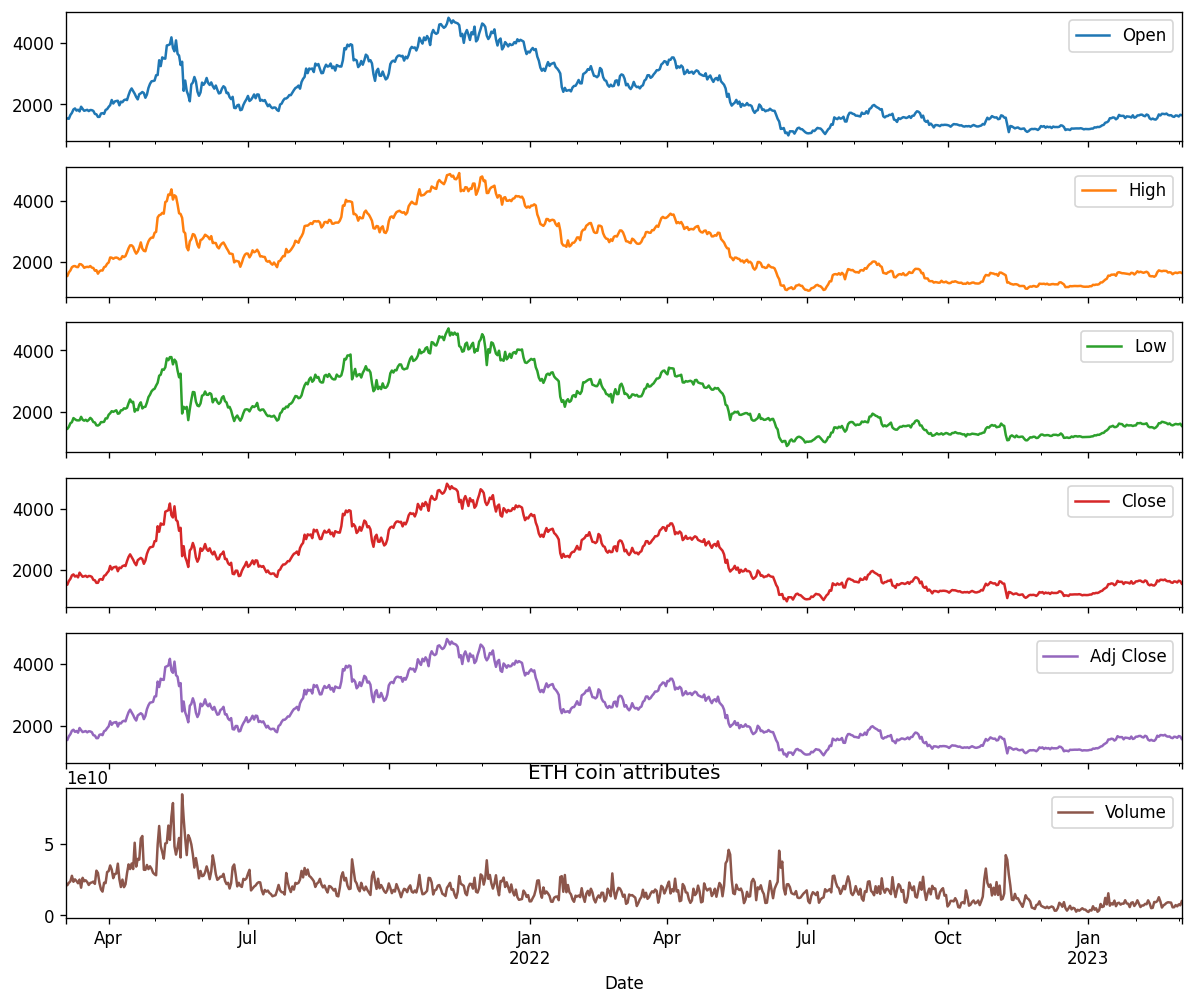

In [129]:
selected_columns = ['Open', 'High', 'Low', 'Close','Adj Close','Volume']
data[selected_columns].plot(subplots=True, figsize=(12,10))
plt.title('ETH coin attributes')
plt.show()

In [130]:
df2=pdr.get_data_yahoo("ETH-USD")
del df2["Adj Close"]


[*********************100%***********************]  1 of 1 completed


In [131]:
df2.describe()

,Open,High,Low,Close,Volume
count,1942.000000,1942.000000,1942.000000,1942.000000,1.942000e+03
mean,1142.991962,1179.112811,1102.186795,1143.409120,1.272837e+10
std,1171.672557,1207.257168,1130.554815,1171.091301,1.066235e+10
min,84.279694,85.342743,82.829887,84.308296,6.217330e+08
25%,214.323799,220.246418,208.710354,214.295589,4.558415e+09
50%,560.891113,581.254242,540.786835,563.559998,1.031033e+10
75%,1715.794861,1759.398468,1672.195099,1715.812286,1.797717e+10
max,4810.071289,4891.704590,4718.039062,4812.087402,8.448291e+10


# Monthly Forecasting <a name="monthlyForecasting"></a>

This plot helps us visualize the max and min values of monthly helping us
infering that:

1. 30th november 2021 has the high maximum price and 31st december 2018 has high minimum price compared to other years
2. From year 2019 to 2020 the maximum and minimum closing prices of Ethereum closing price are near.

In [132]:
df2_daily=df2.resample(rule="D").mean()

In [133]:
df2_daily

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,8.932500e+08
2017-11-10,320.670990,324.717987,294.541992,299.252991,8.859860e+08
2017-11-11,298.585999,319.453003,298.191986,314.681000,8.423010e+08
2017-11-12,314.690002,319.153015,298.513000,307.907990,1.613480e+09
2017-11-13,307.024994,328.415009,307.024994,316.716003,1.041890e+09
...,...,...,...,...,...
2023-02-28,1634.502441,1644.435791,1602.428101,1605.895142,6.323677e+09
2023-03-01,1606.040405,1663.433716,1601.548584,1663.433716,7.701847e+09
2023-03-02,1663.549072,1672.051147,1622.599976,1647.319336,7.080951e+09


<AxesSubplot:xlabel='Date'>

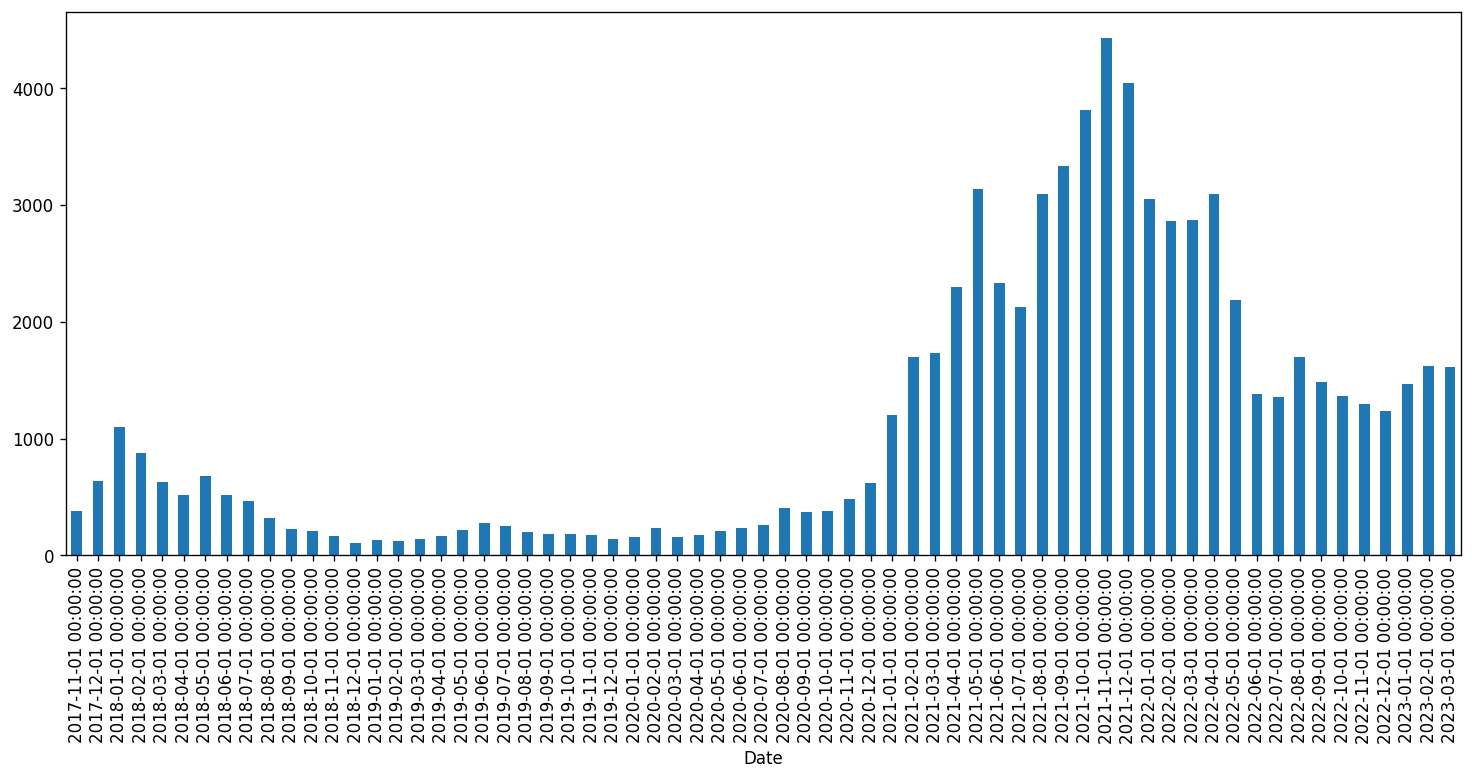

In [134]:
df2['Close'].resample(rule='MS').mean().plot(kind="bar",figsize=(15,6))

# Stationarity check and seasonal decomposition<a name="StationarityCheck"></a>

##Stationarity check

If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

In [135]:
import statsmodels.api as sm

<Figure size 3600x1200 with 0 Axes>

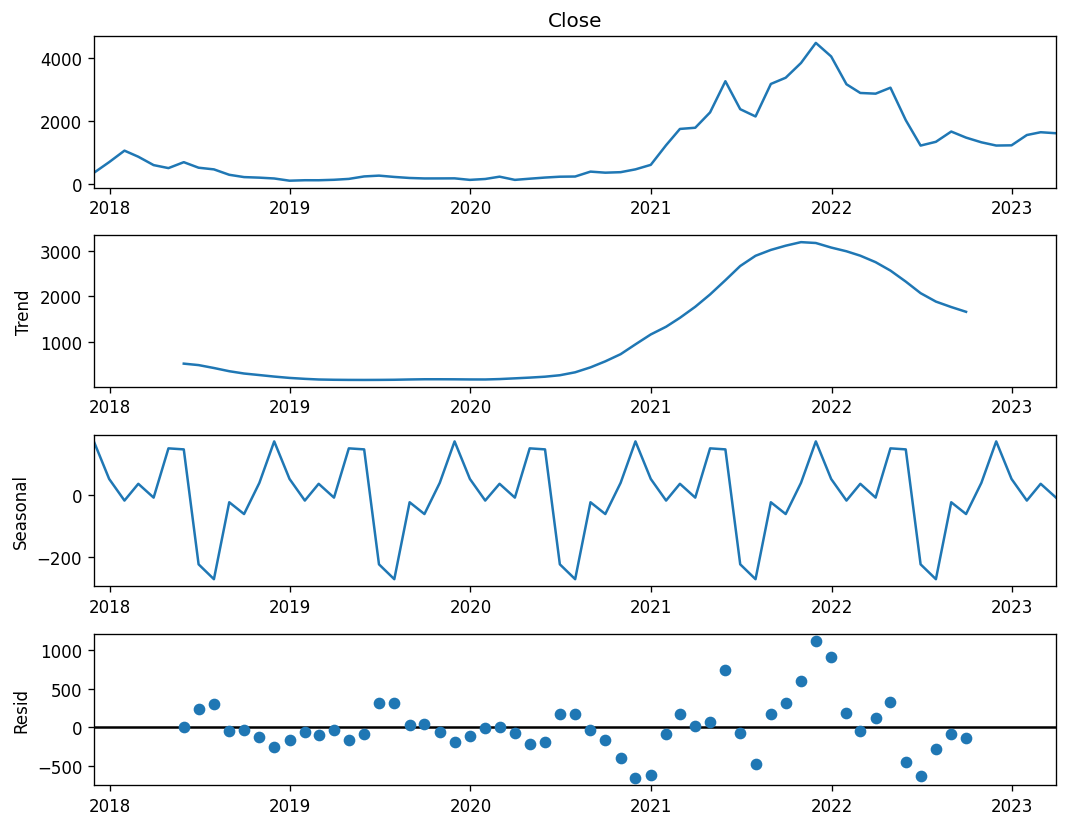

In [136]:
plt.figure(figsize=[30,10])
sm.tsa.seasonal_decompose(df2.resample(rule='M').median().Close).plot()
plt.show()

In [137]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adf_test(data['Close'])

ADF Statistics: -1.653678974969406
p- value: 0.45512244333062124
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Seasonal decomposition

Dickey–Fuller test: p=0.455122


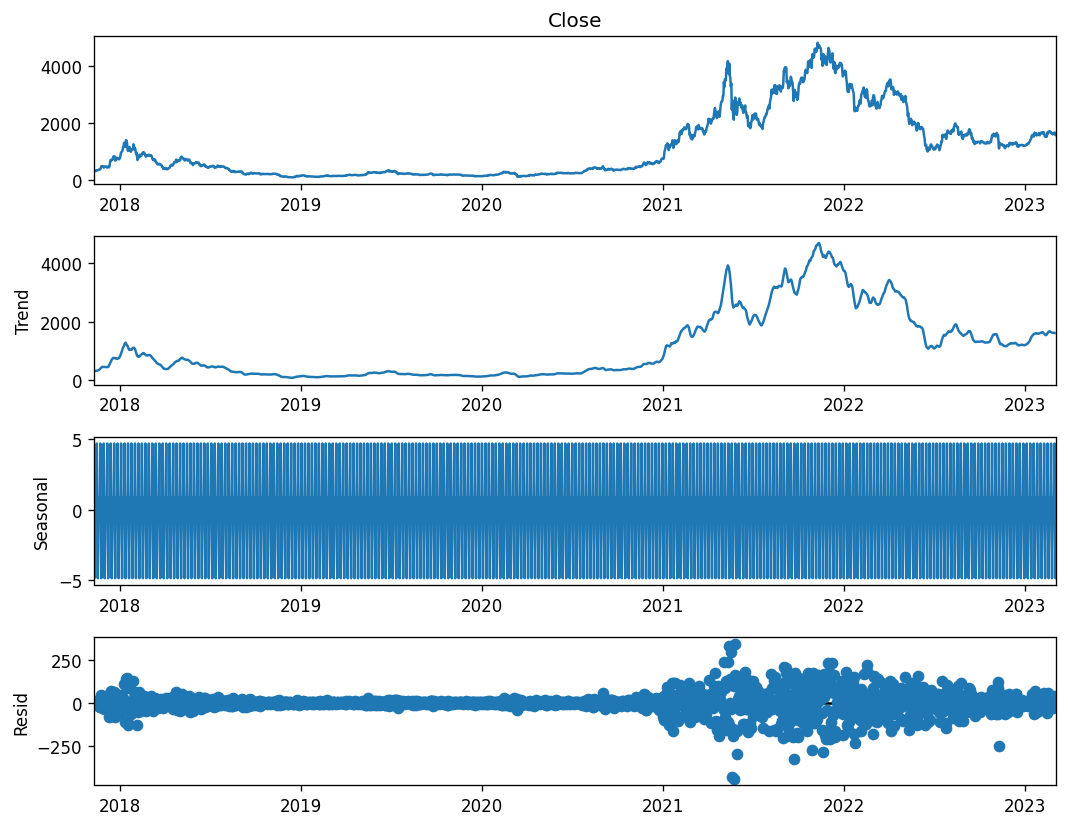

In [138]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df2.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(data.Close)[1])
plt.show()

In [139]:
df2_daily = df2.resample('D').mean()
df2_daily

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,8.932500e+08
2017-11-10,320.670990,324.717987,294.541992,299.252991,8.859860e+08
2017-11-11,298.585999,319.453003,298.191986,314.681000,8.423010e+08
2017-11-12,314.690002,319.153015,298.513000,307.907990,1.613480e+09
2017-11-13,307.024994,328.415009,307.024994,316.716003,1.041890e+09
...,...,...,...,...,...
2023-02-28,1634.502441,1644.435791,1602.428101,1605.895142,6.323677e+09
2023-03-01,1606.040405,1663.433716,1601.548584,1663.433716,7.701847e+09
2023-03-02,1663.549072,1672.051147,1622.599976,1647.319336,7.080951e+09


#Feature Engineering

## Box-Cox Transformation <a name="Transformation"></a>

Lets use the Box-Cox transformation to suppress some of the variance.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p an q for the ARMA model, the AR and MA parameters can then be estimated.

In [140]:
# Box-Cox Transformations
df2_daily['close_box'], lmbda = stats.boxcox(df2_daily.Close)
print("Dickey–Fuller test: p=%f" % adfuller(df2_daily.close_box)[1])

Dickey–Fuller test: p=0.778867


The p-value indicates that series is still not stationary.


## Differencing <a name="Differencing"></a>

When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially xt−xt−1) until we get to a point where the series is stationary. Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us to use the models that account for oscillations.

Once the model has been constructed, we can account for trends separately, by adding the trends component-wise.

In [141]:
# Seasonal differentiation (12 months)
df2_daily['box_diff_seasonal_12'] = df2_daily.close_box - df2_daily.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(df2_daily.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.000000


Dickey–Fuller test: p=0.000000


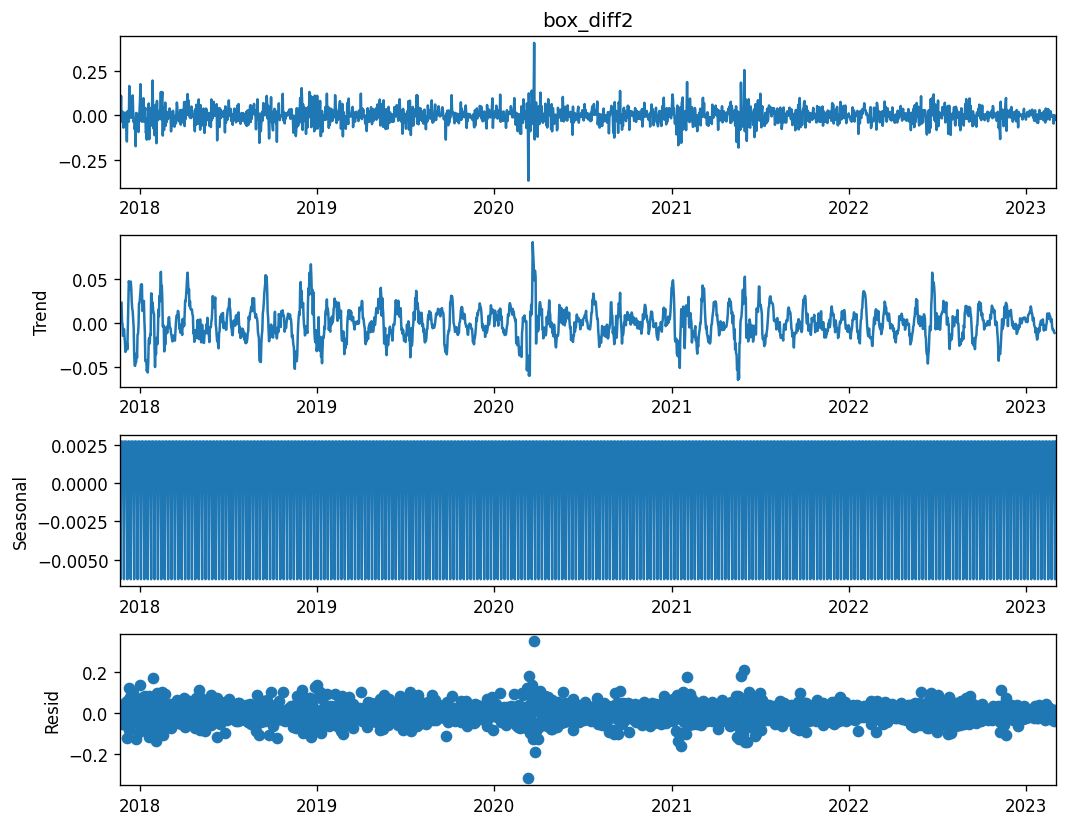

In [142]:
# Regular differentiation
df2_daily['box_diff2'] = df2_daily.box_diff_seasonal_12 - df2_daily.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(df2_daily.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(df2_daily.box_diff2[13:])[1])

plt.show()

In [143]:
df2_daily.Close

Date
2017-11-09     320.884003
2017-11-10     299.252991
2017-11-11     314.681000
2017-11-12     307.907990
2017-11-13     316.716003
                 ...     
2023-02-28    1605.895142
2023-03-01    1663.433716
2023-03-02    1647.319336
2023-03-03    1569.167603
2023-03-04    1570.659912
Freq: D, Name: Close, Length: 1942, dtype: float64

## Autocorrelation  <a name="Autocorrelation"></a>

Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals. 

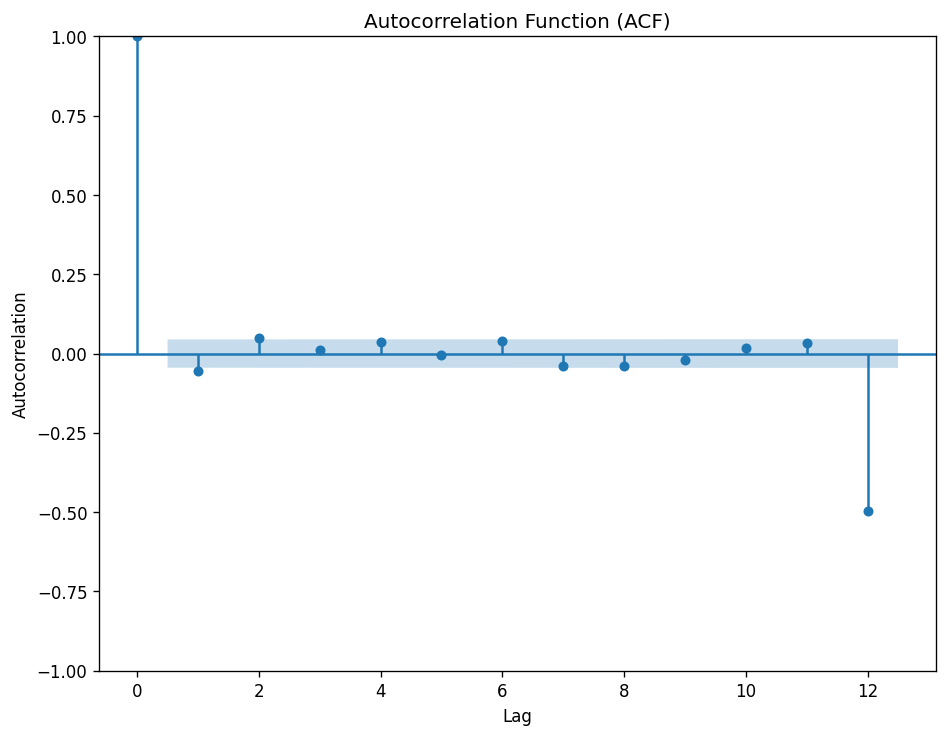

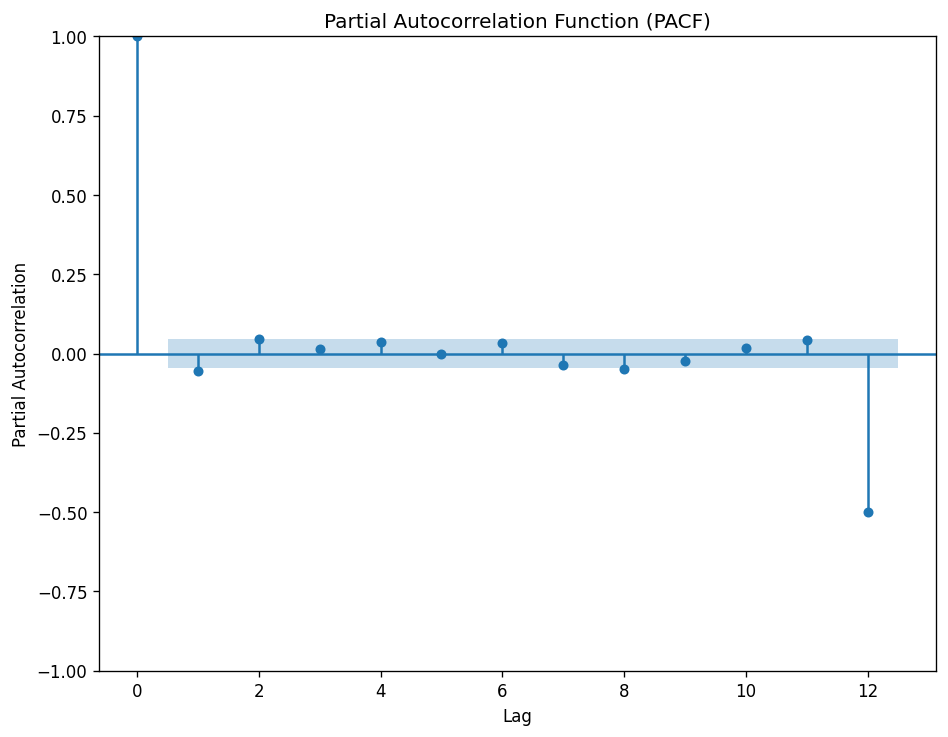

In [167]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sm.graphics.tsa.plot_acf(df2_daily.box_diff2[13:], lags=12)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF)")
plt.show()
sm.graphics.tsa.plot_pacf(df2_daily.box_diff2[13:], lags=12)
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()


There is a positive correlation with the first 10 lags that is perhaps significant for the first 2-3 lags.

A good starting point for the AR parameter of the model may be 3.

Lets try out autocorrelation on the differences...

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models. 

# ARIMA Model  <a name="ARIMAModel"/>
AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

     

1.  p - the number of lag observations to include in the model, or lag order.(AR)
2.  d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
3.  q - the size of the moving average window, also called the order of moving average.(MA)


A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.
A value of 0 for a parameter indicates to not use that element of the model. 

## Parameter Selection

We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with ARIMA() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [146]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings('ignore')
# Initial approximation of parameters
qs = range(0, 4)
ps = range(0, 4)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = ARIMA(df2_daily.close_box, order=(param[0], d, param[1])).fit()
    except:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [147]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters          aic
8      (2, 0) -7794.267981
9      (2, 1) -7794.173404
2      (0, 2) -7794.148210
11     (2, 3) -7793.748883
6      (1, 2) -7793.661035


In [148]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                 1942
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3900.134
Date:                Sat, 04 Mar 2023   AIC                          -7794.268
Time:                        07:25:15   BIC                          -7777.555
Sample:                    11-09-2017   HQIC                         -7788.122
                         - 03-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0428      0.016     -2.721      0.007      -0.074      -0.012
ar.L2          0.0603      0.021      2.861      0.004       0.019       0.102
sigma2         0.0011   1.25e-05     84.399      0.0

##Prediction
## Validation <a name="validationSARIMAX"></a>

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So lets calcualte RMSE for the one-step ahead predictions starting from 2018, through to the end of 2022.

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So lets calcualte RMSE for the one-step ahead predictions starting from 2018, through to the end of 2022.

In [ ]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

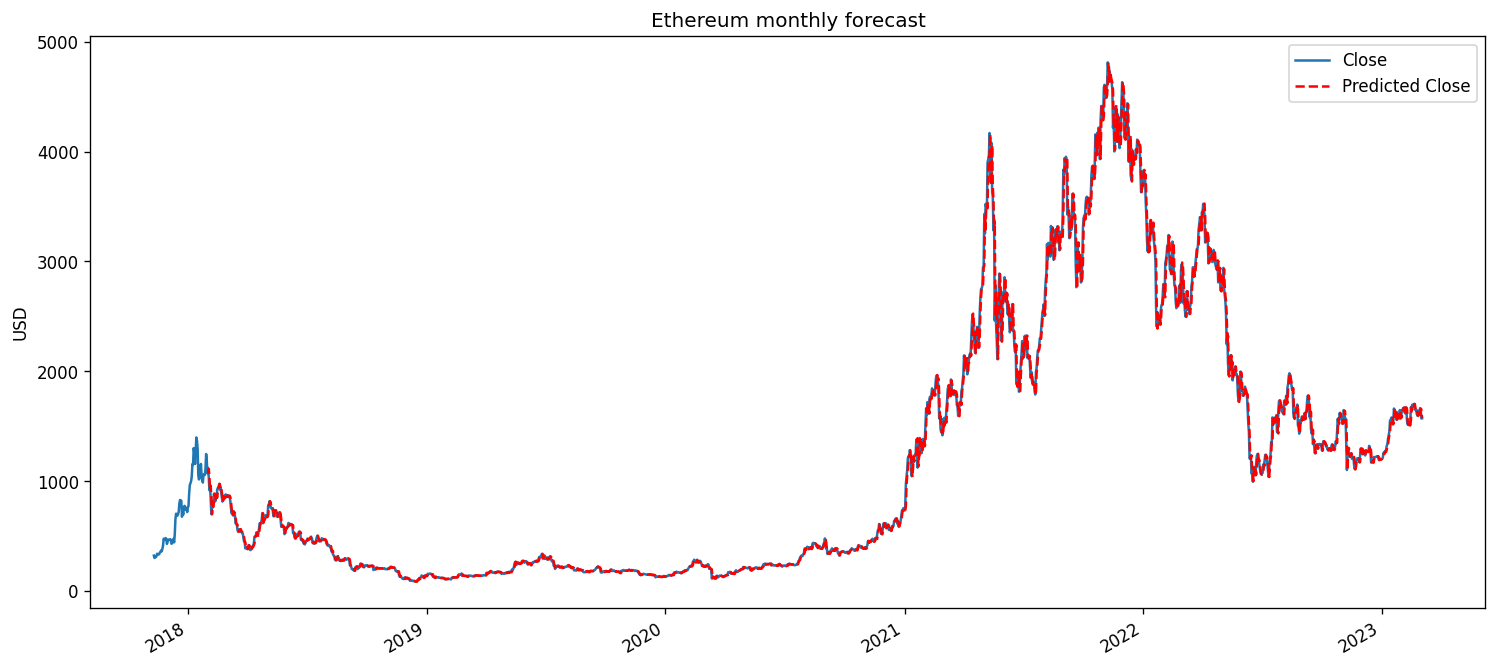

In [152]:
# Prediction
df2_daily_pred = df2_daily[['Close']]
date_list = [datetime(2022, 12, 31), datetime(2023, 1, 1), datetime(2023, 1, 2), datetime(2023, 1, 3)]
future = pd.DataFrame(index=date_list, columns= df2_daily.columns)
df2_daily_pred = pd.concat([df2_daily_pred, future])

df2_daily_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2023, 3, 31)), lmbda)


plt.figure(figsize=(15,7))
df2_daily_pred.Close.plot()
df2_daily_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Ethereum monthly forecast')
plt.ylabel('USD')
plt.show()

In [153]:
df2_daily_pred.Close.tail()

2023-03-04    1570.659912
2022-12-31            NaN
2023-01-01            NaN
2023-01-02            NaN
2023-01-03            NaN
Name: Close, dtype: float64

In [154]:
y_forecasted = df2_daily_pred.forecast
y_truth = df2_daily_pred['2018-1-31':'2022-11-30'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 80.21
